In [1]:
#Demonstrates k Nearest Neighbors

#Import packages
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/Users/jacobeppley/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacobeppley/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Load data
block_shape = gpd.read_file("allegheny_county_census_block_groups_2016.zip")
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("testing_data.csv")
del train_data["Unnamed: 0"]
del test_data["Unnamed: 0"]

In [ ]:
#Let's make a map!
#And filter to a certain year/quarter
q2_2022 = train_data.drop(train_data[train_data['year_quarter'] != "2024 Q2"].index)
q2_2022['geometry'] = gpd.GeoSeries.from_wkt(q2_2022['geometry'])
q2_2022 = gpd.GeoDataFrame(q2_2022, crs="EPSG:4326")

In [ ]:
q2_2022.explore(
    column = 'counts',
    tooltip = ['geoid','call_year', 'call_quarter', 'counts'],
    tiles = 'CartoDB positron',
    cmap = "gnuplot2_r",
    style_kwds=dict(color="black")
)

In [ ]:
#Starting time series visuals
geoid_list = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)

In [ ]:
test_data.head(40)

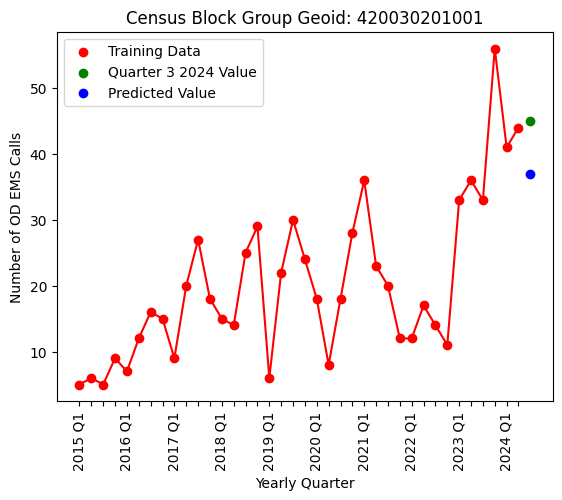

KNN Prediction: 37 Actual Q3 2024: 45 Residual: 8 census block group 420030201001


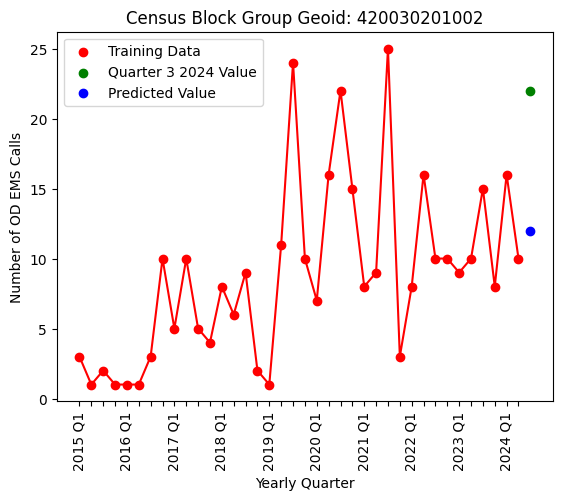

KNN Prediction: 12 Actual Q3 2024: 22 Residual: 10 census block group 420030201002


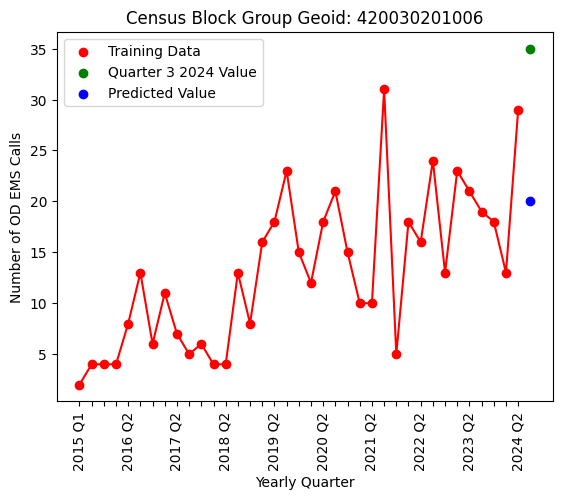

KNN Prediction: 20 Actual Q3 2024: 35 Residual: 15 census block group 420030201006


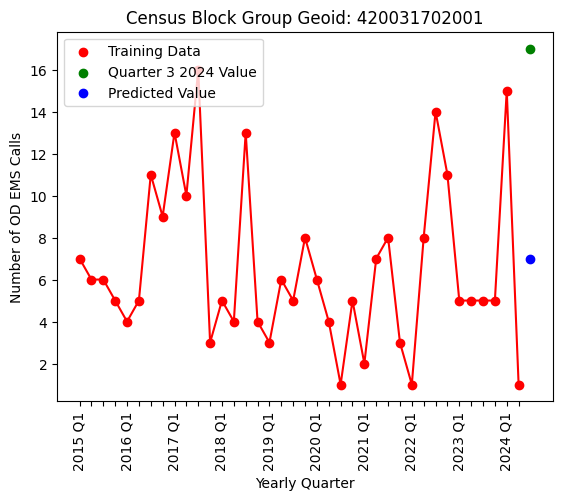

KNN Prediction: 7 Actual Q3 2024: 17 Residual: 10 census block group 420031702001


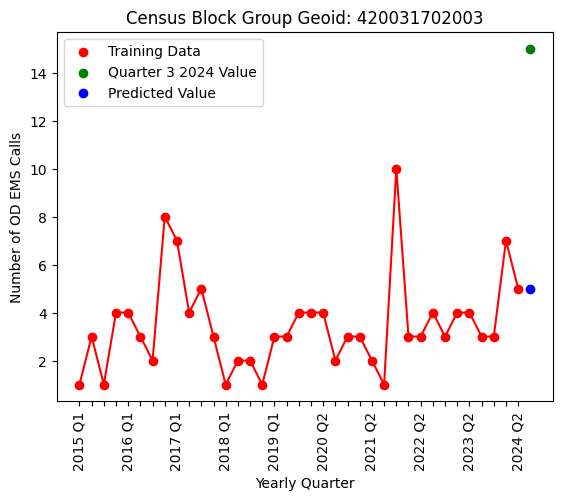

KNN Prediction: 5 Actual Q3 2024: 15 Residual: 10 census block group 420031702003


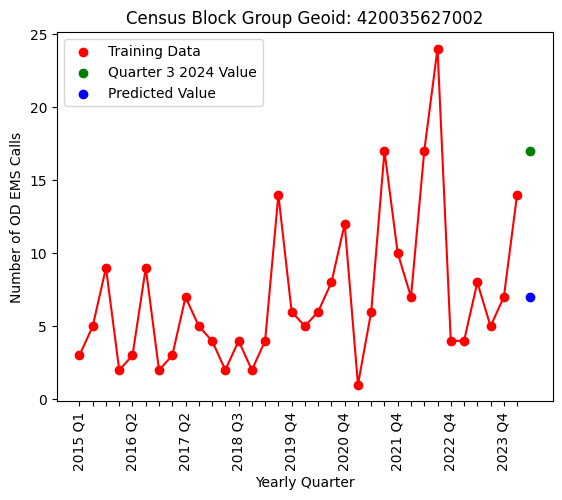

KNN Prediction: 7 Actual Q3 2024: 17 Residual: 10 census block group 420035627002


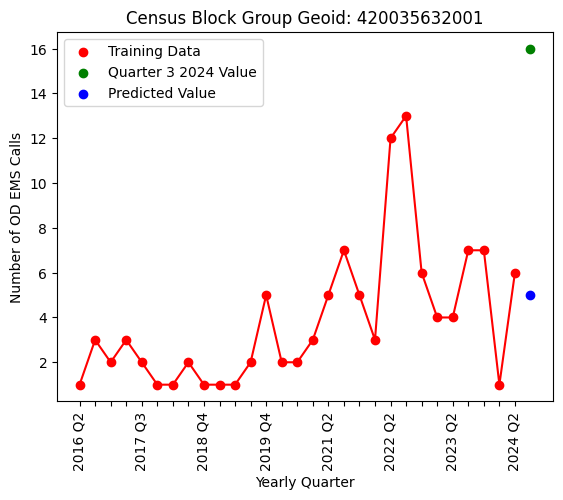

KNN Prediction: 5 Actual Q3 2024: 16 Residual: 11 census block group 420035632001


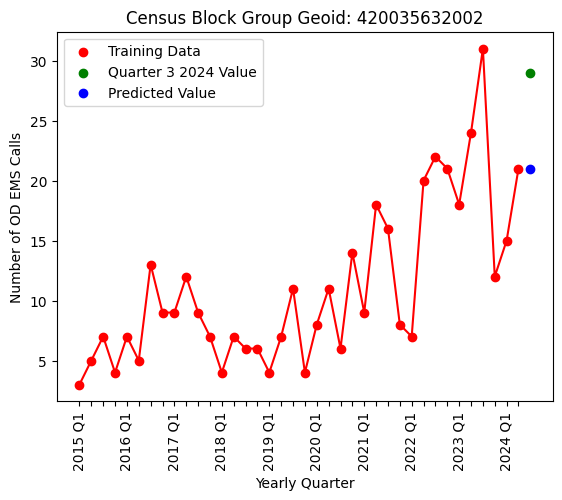

KNN Prediction: 21 Actual Q3 2024: 29 Residual: 8 census block group 420035632002
Average Residual: 1.5707656612529002


In [ ]:
#Fiddling with knn
avg_residual = []
geoid_list = []
avg_abs_residual = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)
for i in range(len(geoid_list)):
    id_map_test = train_data.drop(train_data[train_data['geoid'] != geoid_list[i]].index)
    id_map_test.reset_index(inplace = True)
    del id_map_test["index"]
    if len(id_map_test["geoid"]) >= 20:
        total_num = len(id_map_test["geoid"])
        neighbor_num = int(math.ceil(math.sqrt(total_num)))
        comp_nums = []
        real_count = 0 #If the geoid is not in the test data, then it is 0
        for j in range(total_num - neighbor_num, total_num):
            comp_nums.append(id_map_test["counts"][j])
        prediction = math.ceil(sum(comp_nums)/len(comp_nums))
        for test_id in range(len(test_data["geoid"])):
            if test_data["geoid"][test_id] == geoid_list[i]: #If the test data geoid is in there, then the count is not 0
                real_count = test_data["counts"][test_id]
        residual = real_count - prediction
        abs_residual = abs(residual)
        avg_residual.append(residual)
        avg_abs_residual.append(abs_residual)
        #Commented out as to not create a bunch of graphs (for now)
        #plt.scatter(id_map_test["year_quarter"], id_map_test["counts"], color = "red", label = "Training Data")
        #plt.scatter(test_data["year_quarter"][0], real_count, color = "green", label = "Quarter 3 2024 Value")
        #plt.scatter(test_data["year_quarter"][0], prediction, color = "blue", label = "Predicted Value")
        #plt.plot(id_map_test["year_quarter"], id_map_test["counts"], color = "red")
        #plt.xlabel('Yearly Quarter')
        #plt.ylabel('Number of OD EMS Calls')
        #plt.title("Census Block Group Geoid: " + str(id_map_test["geoid"][0]))
        #plt.xticks(np.arange(0,total_num,1), [id_map_test["year_quarter"][i] if i in range(0,total_num,4) else '' for i in range(total_num)], rotation = 90)
        #plt.legend(loc="upper left")
        #plt.show()
        print("KNN Prediction:",prediction,"Actual Q3 2024:",real_count,"Residual:",residual,"census block group",geoid_list[i])
print("Average Residual:",sum(avg_abs_residual)/len(avg_abs_residual))
residual_list_og = avg_residual

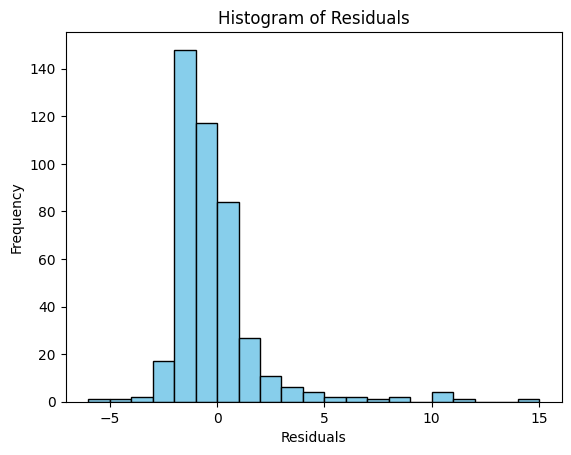

In [ ]:
#Create plot of histogram
plt.hist(avg_residual, bins=21, color='skyblue', edgecolor='black')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
 
# Display the plot
plt.show()

In [ ]:
#Finding the outliers
resid_iqr = stats.iqr(residual_list_og)
q1 = np.quantile(residual_list_og, 0.25)
q3 = np.quantile(residual_list_og, 0.75)
outlier_thresh1 = q1 - 3*resid_iqr
outlier_thresh2 = q3 + 3*resid_iqr

In [ ]:
#Fiddling with knn part 2
#Leaving out outliers where abs(residual) >= 6 (15 in total)
avg_residual = []
geoid_list = []
avg_abs_residual = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)
for i in range(len(geoid_list)):
    id_map_test = train_data.drop(train_data[train_data['geoid'] != geoid_list[i]].index)
    id_map_test.reset_index(inplace = True)
    del id_map_test["index"]
    if len(id_map_test["geoid"]) >= 20:
        total_num = len(id_map_test["geoid"])
        neighbor_num = int(math.ceil(math.sqrt(len(id_map_test["geoid"]))))
        comp_nums = []
        for j in range(total_num - neighbor_num, total_num):
            comp_nums.append(id_map_test["counts"][j])
        prediction = math.ceil(sum(comp_nums)/len(comp_nums))
        for test_id in range(len(test_data["geoid"])):
            if test_data["geoid"][test_id] == geoid_list[i]:
                real_count = test_data["counts"][test_id]
        residual = real_count - prediction
        abs_residual = abs(residual)
        if residual < outlier_thresh2 and residual > outlier_thresh1: #Leaving out blocks with outlier residuals, cuts out 15 in total
            avg_residual.append(residual)
            avg_abs_residual.append(abs_residual)
            #Commented out as to not create a bunch of graphs (for now)
            #plt.scatter(id_map_test["year_quarter"], id_map_test["counts"], color = "red", label = "Training Data")
            #plt.scatter(test_data["year_quarter"][0], real_count, color = "green", label = "Quarter 3 2024 Value")
            #plt.scatter(test_data["year_quarter"][0], prediction, color = "blue", label = "Predicted Value")
            #plt.plot(id_map_test["year_quarter"], id_map_test["counts"], color = "red")
            #plt.xlabel('Time')
            #plt.ylabel('Number of OD EMS Calls')
            #plt.title("Geoid: " + str(id_map_test["geoid"][0]))
            #plt.xticks(rotation=90)
            #plt.legend(loc="upper left")
            #plt.show()
            print("KNN Prediction:",prediction,"Actual Q3 2024:",real_count,"Residual:",residual)
print("Average Residual:",sum(avg_abs_residual)/len(avg_abs_residual))

KNN Prediction: 19 Actual Q3 2024: 13 Residual: -6
KNN Prediction: 4 Actual Q3 2024: 6 Residual: 2
KNN Prediction: 4 Actual Q3 2024: 2 Residual: -2
KNN Prediction: 2 Actual Q3 2024: 1 Residual: -1
KNN Prediction: 60 Actual Q3 2024: 65 Residual: 5
KNN Prediction: 2 Actual Q3 2024: 3 Residual: 1
KNN Prediction: 13 Actual Q3 2024: 18 Residual: 5
KNN Prediction: 6 Actual Q3 2024: 7 Residual: 1
KNN Prediction: 3 Actual Q3 2024: 7 Residual: 4
KNN Prediction: 8 Actual Q3 2024: 6 Residual: -2
KNN Prediction: 2 Actual Q3 2024: 6 Residual: 4
KNN Prediction: 2 Actual Q3 2024: 6 Residual: 4
KNN Prediction: 2 Actual Q3 2024: 6 Residual: 4
KNN Prediction: 4 Actual Q3 2024: 6 Residual: 2
KNN Prediction: 5 Actual Q3 2024: 4 Residual: -1
KNN Prediction: 4 Actual Q3 2024: 1 Residual: -3
KNN Prediction: 2 Actual Q3 2024: 6 Residual: 4
KNN Prediction: 2 Actual Q3 2024: 1 Residual: -1
KNN Prediction: 3 Actual Q3 2024: 5 Residual: 2
KNN Prediction: 6 Actual Q3 2024: 5 Residual: -1
KNN Prediction: 2 Actual Q

In [ ]:
outlier_thresh1

-8.0

In [ ]:
print(len(avg_abs_residual))

417


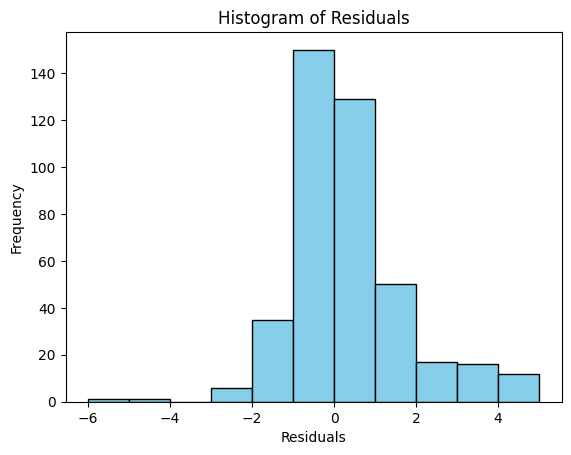

In [ ]:
#Create plot of histograms
plt.hist(avg_residual, bins=11, color='skyblue', edgecolor='black')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
 
# Display the plot
plt.show()

In [ ]:
#Testing different k-values 1-20
geoid_list = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)
for knn_num in range(1,21):
    avg_residual = []
    avg_abs_residual = []
    for geo_id in geoid_list:
        id_map_test = train_data.drop(train_data[train_data['geoid'] != geo_id].index)
        id_map_test.reset_index(inplace = True)
        del id_map_test["index"]
        if len(id_map_test["geoid"]) >= 20:
            total_num = len(id_map_test["geoid"])
            neighbor_num = knn_num
            comp_nums = []
            real_count = 0 #If the geoid is not in the test data, then it is 0
            for j in range(total_num - neighbor_num, total_num):
                comp_nums.append(id_map_test["counts"][j])
            prediction = math.ceil(sum(comp_nums)/len(comp_nums))
            for test_id in range(len(test_data["geoid"])):
                if test_data["geoid"][test_id] == geoid_list[i]: #If the test data geoid is in there, then the count is not 0
                    real_count = test_data["counts"][test_id]
            residual = real_count - prediction
            abs_residual = abs(residual)
            avg_residual.append(residual)
            avg_abs_residual.append(abs_residual)
    print("Average Residual:",sum(avg_abs_residual)/len(avg_abs_residual),"Neighbors:",knn_num)

Average Residual: 1.3665893271461718 Neighbors: 1
Average Residual: 1.443155452436195 Neighbors: 2
Average Residual: 1.5359628770301623 Neighbors: 3
Average Residual: 1.5522041763341068 Neighbors: 4
Average Residual: 1.5591647331786542 Neighbors: 5
Average Residual: 1.580046403712297 Neighbors: 6
Average Residual: 1.5846867749419953 Neighbors: 7
Average Residual: 1.5870069605568446 Neighbors: 8
Average Residual: 1.6009280742459397 Neighbors: 9
Average Residual: 1.631090487238979 Neighbors: 10
Average Residual: 1.6519721577726219 Neighbors: 11
Average Residual: 1.6589327146171693 Neighbors: 12
Average Residual: 1.6728538283062646 Neighbors: 13
Average Residual: 1.677494199535963 Neighbors: 14
Average Residual: 1.6960556844547563 Neighbors: 15
Average Residual: 1.7076566125290022 Neighbors: 16
Average Residual: 1.7006960556844548 Neighbors: 17
Average Residual: 1.7215777262180973 Neighbors: 18
Average Residual: 1.7262180974477959 Neighbors: 19
Average Residual: 1.7308584686774942 Neighbo

In [4]:
#Testing different k-values 1-20 WITHOUT outliers
geoid_list = []
for geo in train_data["geoid"]:
    if geo not in geoid_list:
        geoid_list.append(geo)
for knn_num in range(1,21):
    avg_residual = []
    avg_abs_residual = []
    residual_holder = []
    for i in range(len(geoid_list)):
        id_map_test = train_data.drop(train_data[train_data['geoid'] != geoid_list[i]].index)
        id_map_test.reset_index(inplace = True)
        del id_map_test["index"]
        if len(id_map_test["geoid"]) >= 20:
            total_num = len(id_map_test["geoid"])
            neighbor_num = knn_num
            comp_nums = []
            real_count = 0 #If the geoid is not in the test data, then it is 0
            for j in range(total_num - neighbor_num, total_num):
                comp_nums.append(id_map_test["counts"][j])
            prediction = math.ceil(sum(comp_nums)/len(comp_nums))
            for test_id in range(len(test_data["geoid"])):
                if test_data["geoid"][test_id] == geoid_list[i]: #If the test data geoid is in there, then the count is not 0
                    real_count = test_data["counts"][test_id]
            residual = real_count - prediction
            abs_residual = abs(residual)
            avg_residual.append(residual)
            avg_abs_residual.append(abs_residual)
            resid_iqr = stats.iqr(avg_residual)
            q1 = np.quantile(avg_residual, 0.25)
            q3 = np.quantile(avg_residual, 0.75)
            if residual < q3+3*resid_iqr and residual > q1-3*resid_iqr:
                residual_holder.append(abs_residual)
    print("Average Residual:",sum(residual_holder)/len(residual_holder),"Neighbors:",knn_num)

Average Residual: 1.1818181818181819 Neighbors: 1
Average Residual: 1.2799043062200957 Neighbors: 2
Average Residual: 1.400943396226415 Neighbors: 3
Average Residual: 1.42080378250591 Neighbors: 4
Average Residual: 1.4278959810874705 Neighbors: 5
Average Residual: 1.4397163120567376 Neighbors: 6
Average Residual: 1.471698113207547 Neighbors: 7
Average Residual: 1.5011764705882353 Neighbors: 8
Average Residual: 1.490566037735849 Neighbors: 9
Average Residual: 1.4834123222748816 Neighbors: 10
Average Residual: 1.5071090047393365 Neighbors: 11
Average Residual: 1.509478672985782 Neighbors: 12
Average Residual: 1.5213270142180095 Neighbors: 13
Average Residual: 1.5213270142180095 Neighbors: 14
Average Residual: 1.5402843601895735 Neighbors: 15
Average Residual: 1.54739336492891 Neighbors: 16
Average Residual: 1.542654028436019 Neighbors: 17
Average Residual: 1.5568720379146919 Neighbors: 18
Average Residual: 1.5592417061611374 Neighbors: 19
Average Residual: 1.5602836879432624 Neighbors: 2